# NoSQL (Neo4j) (sesión 7)

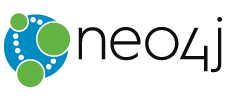

Esta hoja muestra cómo acceder a bases de datos Neo4j y también a conectar la salida con Jupyter.

Se puede utilizar el propio interfaz de Neo4j también en la dirección http://127.0.0.1:7474.

In [3]:
from pprint import pprint as pp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
matplotlib.style.use('ggplot')

Vamos a cargar la extensión `ipython-cypher` para poder lanzar consultas Cypher directamente a través de la hoja.
    
Todas las celdas que comiencen por `%%cypher` y todas las instrucciones Python que comiencen por `%cypher` se enviarán a Neo4j para su interpretación.

In [3]:
!pip install ipython-cypher

    100% |████████████████████████████████| 81kB 1.0MB/s ta 0:00:011
  Running setup.py bdist_wheel for ipython-cypher ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/0e/1e/65/1e0128677b6e6483b90894965f43dd078966270d3dda930044
  Running setup.py bdist_wheel for neo4jrestclient ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/0f/db/72/c3f14a1e15e0adfa09c1bc3c163b15e5730c36516c5fce2f9b
  Running setup.py bdist_wheel for prettytable ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/80/34/1c/3967380d9676d162cb59513bd9dc862d0584e045a162095606
Successfully built ipython-cypher neo4jrestclient prettytable


In [4]:
%load_ext cypher
%config CypherMagic.uri='http://neo4j:7474/db/data'

In [5]:
%config CypherMagic.auto_html=False

In [6]:
%%cypher
match (n) return n limit 10;

0 rows affected.


[]

La carga de datos CSV no se puede realizar directamente desde la hoja, porque la extensión `ipython-cypher` falla por alguna cuestión de codificación UTF-8. Además, el CSV que acepta Neo4j no es estándar y he enviado un fallo para que lo arreglen. Lo han cambiado el la herramienta `neo4j-import`, pero no desde Cypher:

https://github.com/neo4j/neo4j/issues/8472

Mientras tanto, se pueden importar los Posts de Stackoverflow español simplemente añadiendo una barra inversa a cada barra inversa que aparece en el fichero:

    sed -ie 's/\\/\\\\/g' Posts.csv
    
He preparado un conjunto de datos en mi servidor para que los pueda importar Neo4j.

Primero se crea un índice sobre el atributo `Id` de `User`, que se usará después para crear usuarios y relacionarlos con la pregunta o respuesta que se ha leído. Si no se hace esto, la carga del CSV es muy lenta.

In [7]:
%%cypher
CREATE INDEX ON :User(Id);

1 indexes added.


[]

El siguiente código carga el CSV de las preguntas y respuestas. El código primero todos los nodos con la etiqueta `Post`, y después añade la etiqueta `Question` ó `Answer` dependiendo del valor del atributo `PostTypeId`.

In [8]:
%%cypher
USING PERIODIC COMMIT 10000
LOAD CSV WITH HEADERS FROM "http://neuromancer.inf.um.es:8080/es.stackoverflow/Posts-neo4j.csv" AS row
    CREATE (n)
    SET n=row
    SET n :Post
    ;

76278 nodes created.
1596873 properties set.
76278 labels added.


[]

A todas las preguntas, se las etiqueta con `Question`.

In [9]:
%%cypher
MATCH (n:Post {PostTypeId : "1"})
  SET n:Question;

32463 labels added.


[]

A todas las respuestas se las etiqueta con `Answer`.

In [10]:
%%cypher
MATCH (n:Post {PostTypeId : "2"})
  SET n:Answer;

41513 labels added.


[]

Se crea un nodo usuario (o se utiliza uno si ya existe) usando el campo `OwnerUserId`, siempre que no esté vacío.

In [11]:
%%cypher
MATCH (n:Post)
WHERE n.OwnerUserId <> ""
    MERGE (u:User {Id: n.OwnerUserId})
    MERGE (u)-[:WROTE]->(n);

14508 nodes created.
14508 properties set.
75996 relationships created.
14508 labels added.


[]

### El lenguaje Cypher

El lenguaje Cypher tiene una sintaxis de _Query By Example_. Acepta funciones y permite creación y búsqueda de nodos y relaciones. Tiene algunas peculiaridades que veremos a continuación. Por lo pronto, se puede ver un resumen de características en la [Cypher Reference Card](https://neo4j.com/docs/cypher-refcard/current/).

La anterior consulta utiliza la construcción `LOAD CSV` para leer datos CSV dentro de nodos. La cláusula `CREATE` crea nuevos nodos. La `SET` permite poner valores a las propiedades de los nodos.

En el caso de la consulta de arriba, a todos los datos leídos se les copia los datos de la línea (primer `SET`). Después, dependiendo del valor de `PostTypeId`, se les etiqueta como `:Question` o como `:Answer`. Si tienen un usuario asignado a través de `OwnerUserId`, se añade un usuario si no existe y se crea la relación `:WROTE`.

También hay otros posts especiales que no eran preguntas ni respuestas. A estos no se les asigna una segunda etiqueta:

In [12]:
%%cypher
match (n:Post) WHERE size(labels(n)) = 1 RETURN n;

2302 rows affected.


[[{'CreationDate': '2015-10-30T16:53:47.187',
   'Score': '0',
   'OwnerUserId': '24',
   'LastActivityDate': '2016-10-10T02:58:50.127',
   'CommentCount': '0',
   'LastEditorUserId': '15867',
   'LastEditDate': '2016-10-10T02:58:50.127',
   'PostTypeId': '5',
   'Id': '14',
   'Body': '<p><strong>¿Qué es C ++?</strong></p><br/><br/><p>C ++ es de tipado estático (statically typed), (por lo general) compilado, multi-paradigma, que no debe confundirse con C o C ++ / CLI. Se desarrolló en la década de 1980 por Bjarne Stroustrup, inicialmente como un conjunto de extensiones para el lenguaje de programación C. Basándose en C, C ++ ha mejorado la seguridad de tipos y ha añadido soporte para la gestión automática de recursos, la orientación a objetos, programación genérica, y el manejo de excepciones, entre otras características.</p><br/><br/><p><strong>Hola Mundo - Tu Primer Programa</strong></p><br/><br/><p>Código del programa, guardado en <code>holaMundo.cpp</code>:</p><br/><br/><pre><code>using namespace std;<br/>int main()<br/>{<br/>   cout << "Hola mundo" << endl;<br/><br/>   return 0;<br/>}<br/></code></pre><br/><br/><p>Más información:</p><br/><br/><ul><br/><li><a href="https://es.wikipedia.org/wiki/C%2B%2B" rel="nofollow">Artículo sobre C++ en Wikipedia</a></li><br/></ul><br/>'}],
 [{'CreationDate': '2015-10-30T16:53:47.187',
   'Score': '0',
   'OwnerUserId': '24',
   'LastActivityDate': '2015-12-05T20:51:37.347',
   'CommentCount': '0',
   'LastEditorUserId': '24',
   'LastEditDate': '2015-12-05T20:51:37.347',
   'PostTypeId': '4',
   'Id': '15',
   'Body': 'C ++ es un lenguaje de programación de propósito general de nivel intermedio basado en C. Use esta etiqueta para preguntas acerca de código para ser compilado con el compilador de C ++.'}],
 [{'CreationDate': '2015-10-31T01:47:38.807',
   'Score': '0',
   'OwnerUserId': '24',
   'LastActivityDate': '2015-12-06T18:28:40.030',
   'CommentCount': '0',
   'LastEditorUserId': '24',
   'LastEditDate': '2015-12-06T18:28:40.030',
   'PostTypeId': '5',
   'Id': '19',
   'Body': '<p>Delphi es un lenguaje de propósito general para el desarrollo rápido de nativo de Windows, OS X, iOS y aplicaciones Android.</p><br/><br/><p>El nombre utilizado para referirse a la lengua es Delphi, pero los desarrolladores decidierón regresar el nombre original al lenguaje, Object Pascal, restringiendo el nombre al IDE, que se utiliza para ayudar a editar y depurar proyectos de Delphi de manera más eficiente. Es desarrollado por Embarcadero Technologies, y se vende, ya sea como un producto independiente o como parte de RAD Studio, que incluye otros idiomas también.</p><br/><br/><p>Delphi es una mejora del lenguaje de Niklaus Wirth Pascal (y Object Pascal).</p><br/><br/><p>Delphi se originó en 1995 en Borland, evolucionando desde Turbo Pascal, y es la segunda mayor plataforma de desarrollo de Windows después de .NET de Microsoft.</p><br/>'}],
 [{'CreationDate': '2015-10-31T01:47:38.807',
   'Score': '0',
   'OwnerUserId': '24',
   'LastActivityDate': '2015-12-06T04:14:11.190',
   'CommentCount': '0',
   'LastEditorUserId': '24',
   'LastEditDate': '2015-12-06T04:14:11.190',
   'PostTypeId': '4',
   'Id': '20',
   'Body': 'Delphi es un lenguaje para el desarrollo rápido de nativo en Windows, OS X, iOS, y aplicaciones de Android a través del uso de Object Pascal. El nombre hace referencia al lenguaje Delphi, así como su IDE, que se utiliza para ayudar a editar y depurar proyectos de Delphi.'}],
 [{'CreationDate': '2015-10-31T02:13:17.220',
   'Score': '0',
   'OwnerUserId': '24',
   'LastActivityDate': '2016-09-02T11:21:00.667',
   'CommentCount': '0',
   'LastEditorUserId': '127',
   'LastEditDate': '2016-09-02T11:21:00.667',
   'PostTypeId': '5',
   'Id': '21',
   'Body': '<p><strong><em><a href="https://angularjs.org/" rel="nofollow">AngularJS</a></em></strong> es un framework de JavaScript de código abierto.</p><br/><br/><p>Este framework adapta y amplía el HTML tradicional para servir mejor conten

Creamos un índice sobre el `Id` para acelerar las siguientes búsquedas:

In [13]:
%%cypher
CREATE INDEX ON :Post(Id);

1 indexes added.


[]

Añadimos una relación entre las preguntas y las respuestas:

In [14]:
%%cypher
MATCH (a:Answer), (q:Question {Id: a.ParentId})
MERGE (a)-[:ANSWERS]->(q)
;

41513 relationships created.


[]

Las construcciones `%cypher` retornan resultados de los que se puede obtener un `dataframe` de `pandas`:

41513 rows affected.


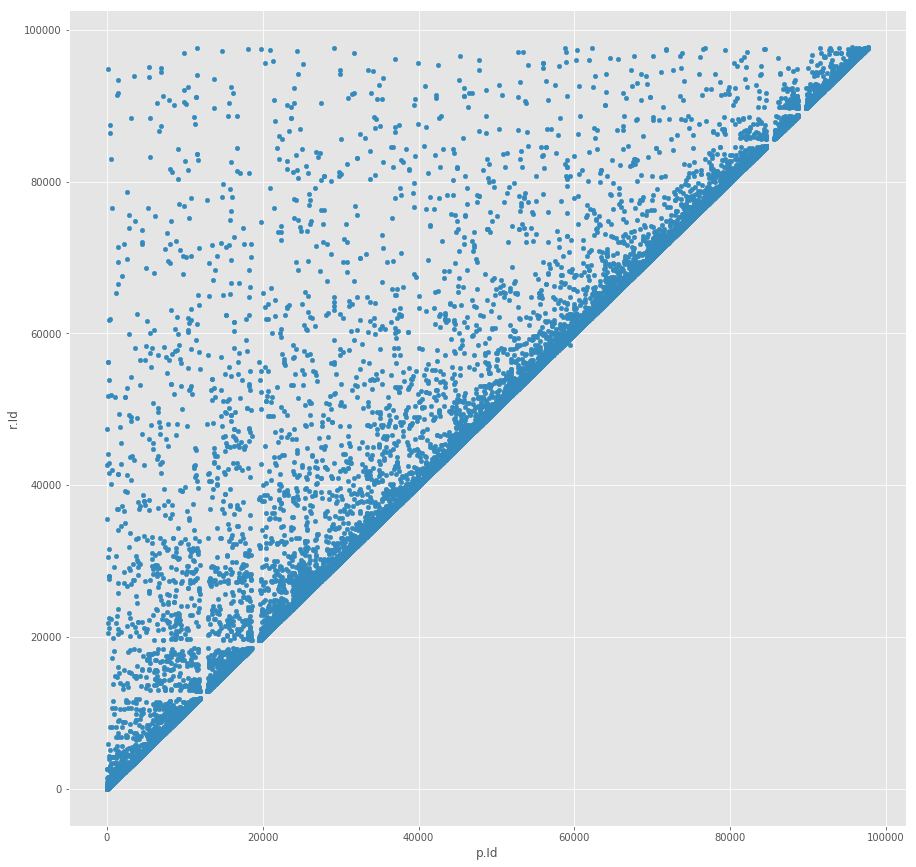

In [15]:
#%%cypher
res = %cypher MATCH q=(r)-[:ANSWERS]->(p) RETURN p.Id,r.Id;
df = res.get_dataframe()
df['r.Id'] = pd.to_numeric(df['r.Id'],downcast='unsigned')
df['p.Id'] = pd.to_numeric(df['p.Id'],downcast='unsigned')

df.plot(kind='scatter',x='p.Id',y='r.Id',figsize=(15,15))

La consulta RQ4 se puede resolver de manera muy fácil. En esta primera consulta se devuelve los nodos:

In [16]:
%%cypher
// RQ4
MATCH
(u1)-[:WROTE]->()-[:ANSWERS]->()<-[:WROTE]-(u2),
(u2)-[:WROTE]->()-[:ANSWERS]->()<-[:WROTE]-(u1)
WHERE u1 <> u2 AND u1.Id < u2.Id
RETURN DISTINCT u1,u2
;

116 rows affected.


[[{'Id': '24'}, {'Id': '25'}],
 [{'Id': '23'}, {'Id': '25'}],
 [{'Id': '24'}, {'Id': '95'}],
 [{'Id': '24'}, {'Id': '463'}],
 [{'Id': '100'}, {'Id': '83'}],
 [{'Id': '100'}, {'Id': '529'}],
 [{'Id': '100'}, {'Id': '638'}],
 [{'Id': '100'}, {'Id': '187'}],
 [{'Id': '227'}, {'Id': '342'}],
 [{'Id': '463'}, {'Id': '801'}],
 [{'Id': '250'}, {'Id': '731'}],
 [{'Id': '22'}, {'Id': '288'}],
 [{'Id': '25'}, {'Id': '288'}],
 [{'Id': '22'}, {'Id': '342'}],
 [{'Id': '120'}, {'Id': '531'}],
 [{'Id': '100'}, {'Id': '729'}],
 [{'Id': '1798'}, {'Id': '729'}],
 [{'Id': '100'}, {'Id': '399'}],
 [{'Id': '100'}, {'Id': '2004'}],
 [{'Id': '1839'}, {'Id': '729'}],
 [{'Id': '399'}, {'Id': '555'}],
 [{'Id': '227'}, {'Id': '400'}],
 [{'Id': '2224'}, {'Id': '729'}],
 [{'Id': '398'}, {'Id': '547'}],
 [{'Id': '100'}, {'Id': '353'}],
 [{'Id': '2230'}, {'Id': '24'}],
 [{'Id': '1184'}, {'Id': '21'}],
 [{'Id': '225'}, {'Id': '25'}],
 [{'Id': '2367'}, {'Id': '342'}],
 [{'Id': '22'}, {'Id': '729'}],
 [{'Id': '100'}, {'Id': '2838'}],
 [{'Id': '2230'}, {'Id': '301'}],
 [{'Id': '342'}, {'Id': '517'}],
 [{'Id': '2676'}, {'Id': '517'}],
 [{'Id': '2004'}, {'Id': '227'}],
 [{'Id': '2230'}, {'Id': '250'}],
 [{'Id': '2004'}, {'Id': '2747'}],
 [{'Id': '2163'}, {'Id': '2230'}],
 [{'Id': '2429'}, {'Id': '250'}],
 [{'Id': '250'}, {'Id': '34'}],
 [{'Id': '191'}, {'Id': '2230'}],
 [{'Id': '6497'}, {'Id': '73'}],
 [{'Id': '250'}, {'Id': '73'}],
 [{'Id': '2171'}, {'Id': '398'}],
 [{'Id': '2832'}, {'Id': '6497'}],
 [{'Id': '2742'}, {'Id': '463'}],
 [{'Id': '2230'}, {'Id': '4684'}],
 [{'Id': '2163'}, {'Id': '250'}],
 [{'Id': '65'}, {'Id': '7661'}],
 [{'Id': '12625'}, {'Id': '250'}],
 [{'Id': '250'}, {'Id': '9897'}],
 [{'Id': '2224'}, {'Id': '73'}],
 [{'Id': '250'}, {'Id': '729'}],
 [{'Id': '12446'}, {'Id': '2230'}],
 [{'Id': '73'}, {'Id': '9897'}],
 [{'Id': '13883'}, {'Id': '14699'}],
 [{'Id': '13558'}, {'Id': '250'}],
 [{'Id': '2366'}, {'Id': '5324'}],
 [{'Id': '3440'}, {'Id': '6491'}],
 [{'Id': '13938'}, {'Id': '6095'}],
 [{'Id': '13938'}, {'Id': '250'}],
 [{'Id': '19600'}, {'Id': '463'}],
 [{'Id': '250'}, {'Id': '6491'}],
 [{'Id': '21775'}, {'Id': '5808'}],
 [{'Id': '1184'}, {'Id': '65'}],
 [{'Id': '18597'}, {'Id': '250'}],
 [{'Id': '15514'}, {'Id': '2429'}],
 [{'Id': '10576'}, {'Id': '250'}],
 [{'Id': '10576'}, {'Id': '6491'}],
 [{'Id': '13938'}, {'Id': '18771'}],
 [{'Id': '15855'}, {'Id': '18124'}],
 [{'Id': '2230'}, {'Id': '535'}],
 [{'Id': '13558'}, {'Id': '13938'}],
 [{'Id': '13735'}, {'Id': '14088'}],
 [{'Id': '16108'}, {'Id': '2230'}],
 [{'Id': '16349'}, {'Id': '25555'}],
 [{'Id': '13938'}, {'Id': '19919'}],
 [{'Id': '18771'}, {'Id': '6491'}],
 [{'Id': '250'}, {'Id': '399'}],
 [{'Id': '65'}, {'Id': '78'}],
 [{'Id': '250'}, {'Id': '29967'}],
 [{'Id': '250'}, {'Id': '78'}],
 [{'Id': '23233'}, {'Id': '6491'}],
 [{'Id': '18771'}, {'Id': '29967'}],
 [{'Id': '19610'}, {'Id': '250'}],
 [{'Id': '301'}, {'Id': '83'}],
 [{'Id': '28050'}, {'Id': '30751'}],
 [{'Id': '30877'}, {'Id': '31132'}],
 [{'Id': '29967'}, {'Id': '638'}],
 [{'Id': '20709'}, {'Id': '29967'}],
 [{'Id': '18376'}, {'Id': '26302'}],
 [{'Id': '29967'}, {'Id': '32268'}],
 [{'Id': '19919'}, {'Id': '9874'}],
 [{'Id': '22112'}, {'Id': '29967'}],
 [{'Id': '19610'}, {'Id': '24'}],
 [{'Id': '14243'}, {'Id': '250'}],
 [{'Id': '18771'}, {'Id': '27881'}],
 [{'Id': '29967'}, {'Id': '6974'}],
 [{'Id': '29967'}, {'Id': '73'}],
 [{'Id': '35232'}, {'Id': '638'}],
 [{'Id': '24'}, {'Id': '301'}],
 [{'Id': '22112'}, {'Id': '2230'}],
 [{'Id': '250'}, {'Id': '27881'}],
 [{'Id': '34270'}, {'Id': '46823'}],
 [{'Id': '16349'}, {'Id': '25360'}],
 [{'Id': '44942'}, {'Id': '44946'}],
 [{'Id': '29967'}, {'Id': '95'}],
 [{'Id': '29967'}, {'Id': '39259'}],
 [{'Id': '13558'}, {'Id': '65'}],
 [{'Id': '13938'}, {'Id': '154'}],
 [{'Id': '29967'}, {'Id': '83'}],
 [{'Id': '29967'}, {'Id': '6491'}],
 [{'Id': '3275'}, {'Id': '35873'}],
 [{'Id': '24137'}, {'Id': '38468'}],
 [{'Id': '48306'}, {'Id': '55380'}],
 [{'Id': '34430'}, {'Id': '6491'}]]

O bien retornar los `Id` de cada usuario:

In [17]:
%%cypher
MATCH
(u1)-[:WROTE]->()-[:ANSWERS]->()<-[:WROTE]-(u2),
(u2)-[:WROTE]->()-[:ANSWERS]->()<-[:WROTE]-(u1)
WHERE u1 <> u2 AND toInt(u1.Id) < toInt(u2.Id)
RETURN DISTINCT u1.Id,u2.Id
ORDER BY toInt(u1.Id)
;

116 rows affected.


[['21', '1184'],
 ['22', '288'],
 ['22', '342'],
 ['22', '729'],
 ['23', '25'],
 ['24', '25'],
 ['24', '95'],
 ['24', '463'],
 ['24', '2230'],
 ['24', '19610'],
 ['24', '301'],
 ['25', '288'],
 ['25', '225'],
 ['34', '250'],
 ['65', '1184'],
 ['65', '7661'],
 ['65', '13558'],
 ['65', '78'],
 ['73', '250'],
 ['73', '2224'],
 ['73', '6497'],
 ['73', '9897'],
 ['73', '29967'],
 ['78', '250'],
 ['83', '100'],
 ['83', '29967'],
 ['83', '301'],
 ['95', '29967'],
 ['100', '529'],
 ['100', '638'],
 ['100', '187'],
 ['100', '729'],
 ['100', '399'],
 ['100', '2004'],
 ['100', '353'],
 ['100', '2838'],
 ['120', '531'],
 ['154', '13938'],
 ['191', '2230'],
 ['227', '342'],
 ['227', '2004'],
 ['227', '400'],
 ['250', '731'],
 ['250', '2429'],
 ['250', '12625'],
 ['250', '9897'],
 ['250', '2230'],
 ['250', '2163'],
 ['250', '729'],
 ['250', '13558'],
 ['250', '6491'],
 ['250', '13938'],
 ['250', '18597'],
 ['250', '399'],
 ['250', '14243'],
 ['250', '19610'],
 ['250', '29967'],
 ['250', '10576'],
 ['250', '27881'],
 ['301', '2230'],
 ['342', '517'],
 ['342', '2367'],
 ['398', '547'],
 ['398', '2171'],
 ['399', '555'],
 ['463', '801'],
 ['463', '2742'],
 ['463', '19600'],
 ['517', '2676'],
 ['535', '2230'],
 ['638', '29967'],
 ['638', '35232'],
 ['729', '1798'],
 ['729', '1839'],
 ['729', '2224'],
 ['2004', '2747'],
 ['2163', '2230'],
 ['2230', '4684'],
 ['2230', '12446'],
 ['2230', '16108'],
 ['2230', '22112'],
 ['2366', '5324'],
 ['2429', '15514'],
 ['2832', '6497'],
 ['3275', '35873'],
 ['3440', '6491'],
 ['5808', '21775'],
 ['6095', '13938'],
 ['6491', '10576'],
 ['6491', '23233'],
 ['6491', '18771'],
 ['6491', '29967'],
 ['6491', '34430'],
 ['6974', '29967'],
 ['9874', '19919'],
 ['13558', '13938'],
 ['13735', '14088'],
 ['13883', '14699'],
 ['13938', '18771'],
 ['13938', '19919'],
 ['15855', '18124'],
 ['16349', '25555'],
 ['16349', '25360'],
 ['18376', '26302'],
 ['18771', '29967'],
 ['18771', '27881'],
 ['20709', '29967'],
 ['22112', '29967'],
 ['24137', '38468'],
 ['28050', '30751'],
 ['29967', '32268'],
 ['29967', '39259'],
 ['30877', '31132'],
 ['34270', '46823'],
 ['44942', '44946'],
 ['48306', '55380']]

Y finalmente, la creación de relaciones `:RECIPROCATE` entre los usuarios. Se introduce también la construcción `WITH`.

`WITH` sirve para introducir "espacios de nombres". Permite importar nombres de filas anteriores, hacer alias con `AS` e introducir nuevos valores con funciones de Cypher. La siguiente consulta es la misma de arriba, RQ4, pero creando relaciones `:RECIPROCATE` entre cada dos usuarios que se ayudan recíprocamente.

In [18]:
%%cypher
// RQ4 creando relaciones de reciprocidad
MATCH
  (u1:User)-[:WROTE]->()-[:ANSWERS]->()<-[:WROTE]-(u2:User),
  (u2)-[:WROTE]->()-[:ANSWERS]->()<-[:WROTE]-(u1)
WHERE u1 <> u2 AND u1.Id < u2.Id
WITH u1 AS user1,u2 AS user2
  MERGE (user1)-[:RECIPROCATE]->(user2)
  MERGE (user2)-[:RECIPROCATE]->(user1)
;

232 relationships created.


[]

También se puede buscar el camino mínimo entre dos usuarios cualesquiera. Si existe un camino a través de alguna pregunta o respuesta, la encontrará. Un ejemplo donde hay una comunicación directa:

In [19]:
%%cypher
MATCH p=shortestPath( (u1:User {Id: '24'})-[*]-(u2:User {Id:'25'}) ) RETURN p

1 rows affected.


[[[{'Id': '24'}, {}, {'Id': '25'}]]]

Mientras que con otro usuario la cadena es más larga:

In [20]:
%%cypher
MATCH p=shortestPath( (u1:User {Id: '324'})-[*]-(u2:User {Id:'25'}) ) RETURN p

1 rows affected.


[[[{'Id': '324'},
   {},
   {'ParentId': '46952',
    'CreationDate': '2017-01-31T14:54:17.660',
    'Score': '0',
    'OwnerUserId': '324',
    'LastActivityDate': '2017-01-31T14:54:17.660',
    'CommentCount': '0',
    'PostTypeId': '2',
    'Id': '46965',
    'Body': '<p>No creo que exista una forma que el programa pueda saber magicamente en que idioma esta escribiendo el usuario.</p><br/><br/><p>Tu mejor solucion, es deshacerte del separador de miles siempre, y utilizar siempre el mismo separador decimal. </p><br/><br/><p>Para ello, deberias primero fijarte si solo viene un separador, y tomar ese como el decimal. (o cambiarlo si no es el q te sirve).<br/>Si en el string vienen los dos, solo quedarse con el ultimo (los otros separan miles) y luego cambiarlo si no es el que te sirve.</p><br/><br/><p>Con esto solucionas tu problema y el usuario puede escribir como le plazca.</p><br/>'},
   {},
   {'CreationDate': '2017-01-31T14:24:23.173',
    'Title': 'Convertir string moneda a double sin saber el formato',
    'ViewCount': '183',
    'LastEditorUserId': '10531',
    'Score': '0',
    'OwnerUserId': '10531',
    'LastActivityDate': '2017-01-31T16:18:03.387',
    'AnswerCount': '2',
    'CommentCount': '2',
    'PostTypeId': '1',
    'LastEditDate': '2017-01-31T14:47:56.393',
    'Id': '46952',
    'AcceptedAnswerId': '46978',
    'Body': '<p>Estoy tratando de pasar un string con valores aleatorios con diferentes formatos de moneda:</p><br/><br/><pre><code>1,222.50<br/>1.222,50<br/>1222.5<br/>1222,500<br/>1222<br/></code></pre><br/><br/><p>A un double para poder insertarlo en la base de datos. Hasta ahora tengo el siguiente código:</p><br/><br/><pre><code>String a1, a2;<br/>a1 = "1.100,50";<br/>a2 = "1,100.50";<br/>NumberFormat nf = NumberFormat.getInstance();<br/>double number = nf.parse(a1).doubleValue();<br/>double number2 = nf.parse(a2).doubleValue();<br/>System.out.println(number);<br/>System.out.println(number2);<br/></code></pre><br/><br/><p>Pero este es el resultado que obtengo:</p><br/><br/><pre><code>1100.5<br/>1.1<br/></code></pre><br/><br/><p>No me está funcionando con el formato inglés. Traté con la función <code>Double.parseDouble(a1)</code> pero tiene problemas con el formato español. Hay alguna manera de pasarlo a Double independientemente del formato que tenga?</p><br/>',
    'Tags': '<java>'},
   {},
   {'Id': '10531'},
   {},
   {'CreationDate': '2016-11-02T16:38:27.230',
    'Title': 'Animación del desplazamiento de los elementos al hacer fadeOut o fadeIn',
    'ViewCount': '112',
    'LastEditorUserId': '73',
    'Score': '3',
    'OwnerUserId': '10531',
    'FavoriteCount': '1',
    'LastActivityDate': '2016-11-02T17:09:16.637',
    'AnswerCount': '2',
    'CommentCount': '0',
    'PostTypeId': '1',
    'LastEditDate': '2016-11-02T16:39:17.467',
    'Id': '31345',
    'AcceptedAnswerId': '31355',
    'Body': '<p>estoy haciendo una pagina en la que al ocurrir un evento hace fadeToggle de algunos elementos. Mi problema reside en saber si hay una manera de que los elementos que no hicieron fadeOut se desplacen de forma mas elegante cuando ocupan el lugar de los que si desaparecieron.</p><br/><br/><p>Acá hice un Jsfiddle para que se entienda mejor</p><br/><br/><p><div class="snippet" data-lang="js" data-hide="false" data-console="true" data-babel="false"><br/><div class="snippet-code"><br/><pre class="snippet-code-js lang-js prettyprint-override"><code>$(\'#boton\').click(function() {<br/>  $(\'#1 ,#2\').fadeToggle();<br/>});</code></pre><br/><pre class="snippet-code-css lang-css prettyprint-override"><code>.circulo {<br/>  display: -webkit-inline-box;<br/>  border: 2px solid black;<br/>  height: 100px;<br/>  width: 100px;<br/>  margin-right: 2%;<br/>  border-radius: 50%;<br/>}</code></pre><br/><pre class="snippet-code-html lang-html prettyprint-override"><code><script src="https://ajax.googleapis.com/ajax/libs/jquery/2.1.1/jquery.min.js"></script><br/><button id="boton" role="button">Click Toggle</button><b

Finalmente se pueden encontrar todos los caminos mínimos en donde se ve que tiene que existir al menos un par pregunta/respuesta entre los usuarios que son recíprocos:

In [21]:
%%cypher
MATCH p=allShortestPaths( (u1:User {Id: '24'})-[*]-(u2:User {Id:'25'}) ) RETURN p

2 rows affected.


[[[{'Id': '24'}, {}, {'Id': '25'}]], [[{'Id': '24'}, {}, {'Id': '25'}]]]

## EJERCICIO: Construir los nodos `:Tag` para cada uno de los tags que aparecen en las preguntas. Construir las relaciones `post-[:TAGGED]->tag` para cada tag y también `tag-[:TAGS]->post`

Para ello, buscar en la ayuda las construcciones `WITH` y `UNWIND` y las funciones `replace()` y `split()` de Cypher. La siguiente consulta debe retornar 5703 resultados:

In [22]:
%%cypher
MATCH (q:Question)
WITH split(replace(q.Tags, "<", ""), ">") AS tags, q AS question
UNWIND tags AS t
    MERGE (tag:Tag {name: t})
    MERGE (tag)-[:TAGS]->(question)
    MERGE (question)-[:TAGGED]->(tag)

1555 nodes created.
1555 properties set.
217090 relationships created.
1555 labels added.


[]

In [23]:
%%cypher
MATCH (t:Tag { name: '' })
 DETACH DELETE t

1 nodes deleted.
64926 relationship deleted.


[]

In [24]:
%%cypher
MATCH p=(t:Tag)-[:TAGS]->(:Question) WHERE t.name =~ "^java$|^c\\+\\+$" RETURN count(p);

1 rows affected.


[[5703]]

In [25]:
%%cypher
MATCH p=(:Question)-[:TAGGED]->(t:Tag) WHERE t.name =~ "^java$|^c\\+\\+$" RETURN count(p);

1 rows affected.


[[5703]]

La siguiente consulta muestra los usuarios que preguntan por cada Tag:

In [26]:
%%cypher
MATCH (t:Tag)-->(:Question)<--(u:User) RETURN t.name,collect(distinct u.Id) ORDER BY t.name;

1549 rows affected.


[['.asmx', ['23683', '43605', '24842', '9885', '4361', '27002', '9039']],
 ['.htaccess',
  ['10365',
   '29516',
   '36157',
   '4718',
   '872',
   '26657',
   '27916',
   '4328',
   '35340',
   '49661',
   '18000',
   '46275',
   '9754',
   '30152',
   '35768',
   '7358',
   '10796',
   '33462',
   '21882',
   '18771',
   '25829',
   '19419',
   '29967',
   '32994',
   '27826',
   '16978',
   '52036',
   '517',
   '11342',
   '26878',
   '3248',
   '13041',
   '18587',
   '37364',
   '14025',
   '21670',
   '2770',
   '2676',
   '8752',
   '9254',
   '54489',
   '9142',
   '12545',
   '55890',
   '51884',
   '27226',
   '30706',
   '15653',
   '5716',
   '20493',
   '31455',
   '47637',
   '10399',
   '18124',
   '37608',
   '11349',
   '55754',
   '9529',
   '5583',
   '5438',
   '36049',
   '1746',
   '6044',
   '55288',
   '37695',
   '7679',
   '16107',
   '54420',
   '6897',
   '5248',
   '10486',
   '4571',
   '18031',
   '23610',
   '25908',
   '27667',
   '45740',
   '9470',
   '6187',
   '15594',
   '52463',
   '166',
   '4530',
   '3947',
   '15481',
   '20709',
   '56955',
   '7498',
   '6046',
   '14132']],
 ['.htpasswd', ['5716']],
 ['.net',
  ['6881',
   '3544',
   '1962',
   '29875',
   '4499',
   '745',
   '21904',
   '28772',
   '2004',
   '16744',
   '55233',
   '22324',
   '24867',
   '7545',
   '57302',
   '15710',
   '33042',
   '26903',
   '35795',
   '51933',
   '30509',
   '29261',
   '4361',
   '30353',
   '13526',
   '29296',
   '34427',
   '24842',
   '6764',
   '30839',
   '12891',
   '54012',
   '57161',
   '1168',
   '2224',
   '531',
   '16449',
   '45739',
   '1482',
   '921',
   '38929',
   '14706',
   '22242',
   '1274',
   '463',
   '3727',
   '41515',
   '54092',
   '12902',
   '3088',
   '28475',
   '27002',
   '26195',
   '34051',
   '15883',
   '38309',
   '35183',
   '9130',
   '4612',
   '7216',
   '12640',
   '22205',
   '822',
   '24364',
   '5723',
   '27634',
   '30038',
   '14211',
   '22395',
   '5715',
   '35781',
   '2947',
   '14461',
   '1473',
   '5997',
   '298',
   '57087',
   '547',
   '7692',
   '35733',
   '46542',
   '7242',
   '37542',
   '33484',
   '33073',
   '32336',
   '54329',
   '22698',
   '4048',
   '7132',
   '53738',
   '4914',
   '34194',
   '4748',
   '9883',
   '6808',
   '22387',
   '51058',
   '21180',
   '5729',
   '10428',
   '15301',
   '5602',
   '27705',
   '22571',
   '2896',
   '33834',
   '10686',
   '21979',
   '30722',
   '15284',
   '51862',
   '4779',
   '3879',
   '47330',
   '55738',
   '26651',
   '30129',
   '15270',
   '28831',
   '29028',
   '6791',
   '21643',
   '8873',
   '38307',
   '56428',
   '39984',
   '21459',
   '7254',
   '40111',
   '27435',
   '3803',
   '25708',
   '8990',
   '28378',
   '30762',
   '14236',
   '23',
   '30514',
   '55451',
   '2247',
   '57448',
   '13432',
   '2883',
   '48401',
   '33213',
   '52400',
   '31656',
   '10952',
   '30131',
   '23697',
   '43085',
   '31660',
   '9947',
   '11354',
   '15439',
   '250',
   '2946',
   '15675',
   '48505',
   '3022',
   '18477',
   '57466',
   '22005',
   '37794',
   '22584',
   '47536',
   '6298',
   '46154',
   '9476',
   '4574',
   '18737',
   '40712',
   '5271',
   '4610',
   '28050',
   '51093',
   '41156',
   '7273',
   '14181',
   '19052',
   '50737',
   '27833',
   '56513',
   '7491',
   '3541',
   '2488',
   '10744',
   '45649',
   '28472',
   '47359',
   '17625',
   '21471',
   '5671',
   '3249',
   '562',
   '15572',
   '3142',
   '56976',
   '55221',
   '5668',
   '13701',
   '2945',
   '48060',
   '15596',
   '29179',
   '40501',
   '5811',
   '15562',
   '45449',
   '44985',
   '3008',
   '5866',
   '49228',
   '4787']],
 ['.net-core', ['30353']],
 ['2d', ['5449', '13724', '2257', '39510', '27229']],
 ['3d',
  ['342',
   '44032',
   '22584',
   '30578',
   '46230',
   '20401',
   '23739',
   '25764',
   '2998']],
 ['abap', ['1098', '19839']],
 ['accesibilidad', ['250', '29967']],
 ['access-control', ['7246']],
 ['accordion', ['33075', '4021',

El mismo `MATCH` se puede usar para encontrar qué conjunto de tags ha usado cada usuario cambiando lo que retornamos:

In [27]:
%%cypher
MATCH (t:Tag)-->(:Question)<--(u:User) RETURN u.Id,collect(distinct t.name) ORDER BY toInt(u.Id);

10939 rows affected.


[['20', ['typescript']],
 ['21',
  ['delphi',
   'string',
   'casting',
   'array',
   'javascript',
   'jquery',
   'android',
   'socket',
   'tcpip',
   'tcp',
   'mysql',
   'datetime',
   'timestamp',
   'sql',
   'join',
   'oracle',
   'oracle-10g',
   'poo',
   'windows',
   'split',
   'sobrecarga',
   'pascal',
   'impresión',
   'lenguaje-compilado']],
 ['22',
  ['array',
   'perl',
   'javascript',
   'jquery',
   'git',
   'nodejs',
   'json',
   'sandbox',
   'seguridad',
   'tipos',
   'booleano',
   'pouchdb',
   'go',
   'conversión-de-tipos',
   'eventos',
   'atómico']],
 ['23',
  ['.net',
   'asp.net-web-api',
   'asp.net',
   'google-maps',
   'angularjs',
   'jasmine',
   'karma-jasmine',
   'javascript',
   'momentjs',
   'c#',
   'git',
   'ajax',
   'mercurial']],
 ['24',
  ['c++',
   'string',
   'casting',
   'android',
   'c++11',
   'c#',
   'java',
   'linux',
   'c',
   'tokens',
   'android-studio',
   'gradle',
   'angularjs-2.0',
   'angular2-template',
   'vscode',
   'arquitectura',
   'compilador',
   'gnu',
   'interprete',
   'terminal']],
 ['25',
  ['c++',
   'array',
   'javascript',
   'c++11',
   'c#',
   'java',
   'git',
   'nodejs',
   'xml',
   'licencias',
   'código-abierto',
   'visual-studio-2015',
   'revisión-de-código',
   'groovy']],
 ['27', ['javascript', 'android', 'reactjs', 'react-native']],
 ['29', ['ruby-on-rails', 'ruby', 'vistas', 'api', 'http', 'post']],
 ['34', ['ruby-on-rails', 'html', 'css']],
 ['35', ['asp.net', 'javascript', 'bower', 'kendoui', 'knockoutjs']],
 ['37', ['ios', 'xcode', 'lista', 'elixir']],
 ['39',
  ['ruby-on-rails', 'ruby', 'javascript', 'nodejs', 'ecmascript-2015', 'es6']],
 ['45', ['sql', 'tsql']],
 ['65',
  ['array',
   'javascript',
   'jquery',
   'google-apps-script',
   'google-hoja-de-calculo',
   'google-forms',
   'google-documentos',
   'html',
   'css',
   'regex',
   'optimización',
   'dom',
   'excel',
   'bookmarklet',
   'gmail',
   'google-chrome',
   'google-drive',
   'revisión-de-código',
   'geo-localizacion',
   'fecha',
   'formulas',
   'csv',
   'google-sites',
   'google-drive-sdk',
   'es2016',
   'google-caja']],
 ['72', ['c#']],
 ['73',
  ['javascript',
   'php',
   'ajax',
   'laravel',
   'laravel-5',
   'html',
   'css',
   'html5',
   'css3',
   'condiciones',
   'revisión-de-código']],
 ['74', ['array', 'python', 'numpy', 'yield', 'pandas']],
 ['75',
  ['ruby',
   'git',
   'control-de-versiones',
   'reactjs',
   'conflictos',
   'bundler',
   'gemfile']],
 ['77', ['sql', 'sql-server']],
 ['78',
  ['asp.net',
   'javascript',
   'sql',
   'c#',
   'html',
   'windows-forms',
   'sql-server',
   'sharepoint',
   'sharepoint-online',
   'excel',
   'windows',
   'ms-access-2010',
   'google-chrome',
   'consola',
   'jquery-datepicker',
   'revisión-de-código',
   'vb6',
   'regsvr32',
   'webforms',
   'impresión',
   'ddl',
   'ms-access',
   'sftp']],
 ['83',
  ['string',
   'bash',
   'archivo',
   'python',
   'git',
   'html',
   'css',
   'linux',
   'shell',
   'sed',
   'awk',
   'regex',
   'git-commit',
   'coma-flotante',
   'zsh',
   'python-2.7',
   'git-push',
   'git-merge',
   'css3',
   'nodejs',
   'npm',
   'python-3.x',
   'sql-server',
   'unix',
   'grep',
   'ascii',
   'crontab',
   'vim',
   'find',
   'redux',
   'cron',
   'parámetros',
   'números-enteros',
   'línea-de-comandos',
   'shell-interactiva',
   'vi',
   'diccionarios',
   'git-rebase']],
 ['90', ['mysql', 'sql']],
 ['92', ['c#', 'wpf', 'xaml', 'reflexión']],
 ['93', ['javascript', 'java', 'css', 'eclipse', 'visual-studio', 'swt']],
 ['95',
  ['string',
   'javascript',
   'android',
   'java',
   'regex',
   'google-newsstand-producer',
   'rss',
   'objective-c',
   'swift',
   'base-de-datos',
   'uiwebview',
   'dialogo',
   'android-glide',
   'jira']],
 ['100',
  ['string',
   'array',
   'lista',
   'javascript',
   'jquery',
   'android',
   'mysql',
   'datetime',
   'bash',
   'archivo',
   'python',
   'lin

## EJERCICIO: Relacionar cada usuario con los tags de sus preguntas a través de la relación `:INTERESTED_IN`.

In [28]:
%%cypher
MATCH
  (u:User)-[:WROTE]->(:Question)-[:TAGGED]->(t:Tag)
WITH u AS user, t AS tag
  MERGE (user)-[:INTERESTED_IN]->(tag)
;

45059 relationships created.


[]

## EJERCICIO: Recomendar a los usuarios _tags_ sobre los que podrían estar interesados en base a _tags_ en los que los usuarios con los que están relacionados con `:RECIPROCATE` están interesados y ellos no, ordenado por número de usuarios interesados en cada _tag_.

In [8]:
%%cypher
CREATE INDEX ON :Tag(name);

1 indexes added.


[]

In [12]:
%%cypher
MATCH
    (u:User)-[:INTERESTED_IN]->(t:Tag)
WITH u, collect(distinct t.name) AS intTags
MATCH
    (u:User)-[:RECIPROCATE]->(u2:User)-[:INTERESTED_IN]->(t:Tag)
WITH u, intTags, t { .name, recUsers: count(distinct u2) } AS tag ORDER BY tag.recUsers DESC
WITH u, intTags, collect(distinct tag) AS recomTags
RETURN u.Id, filter(t IN recomTags WHERE not t.name in intTags)
ORDER BY toInt(u.Id);

112 rows affected.


[['21',
  [{'recUsers': 1, 'name': 'google-hoja-de-calculo'},
   {'recUsers': 1, 'name': 'gimp'},
   {'recUsers': 1, 'name': 'google-forms'},
   {'recUsers': 1, 'name': 'oracle-11g'},
   {'recUsers': 1, 'name': 'google-apps-script'},
   {'recUsers': 1, 'name': 'consola'},
   {'recUsers': 1, 'name': 'sql-server'},
   {'recUsers': 1, 'name': 'regex'},
   {'recUsers': 1, 'name': 'delphi-2010'},
   {'recUsers': 1, 'name': 'sqldeveloper'},
   {'recUsers': 1, 'name': 'sqlfiddle'},
   {'recUsers': 1, 'name': 'python-2.7'},
   {'recUsers': 1, 'name': 'notepad++'},
   {'recUsers': 1, 'name': 'archivo'},
   {'recUsers': 1, 'name': 'python'},
   {'recUsers': 1, 'name': 'proceso'}]],
 ['22',
  [{'recUsers': 2, 'name': 'css'},
   {'recUsers': 2, 'name': 'html'},
   {'recUsers': 2, 'name': 'regex'},
   {'recUsers': 1, 'name': 'matrices-asociativas'},
   {'recUsers': 1, 'name': 'ordenamiento'},
   {'recUsers': 1, 'name': 'gpg'},
   {'recUsers': 1, 'name': 'php'},
   {'recUsers': 1, 'name': 'linux'},
   {'recUsers': 1, 'name': 'google-maps'},
   {'recUsers': 1, 'name': 'mysql'},
   {'recUsers': 1, 'name': 'joomla3'},
   {'recUsers': 1, 'name': 'poo'},
   {'recUsers': 1, 'name': 'xpath'},
   {'recUsers': 1, 'name': 'bash'},
   {'recUsers': 1, 'name': 'yii2'},
   {'recUsers': 1, 'name': 'magento2'},
   {'recUsers': 1, 'name': 'ecmascript-2015'},
   {'recUsers': 1, 'name': 'eclipse'},
   {'recUsers': 1, 'name': 'coffeescript'},
   {'recUsers': 1, 'name': 'sqldeveloper'},
   {'recUsers': 1, 'name': 'java-swing'},
   {'recUsers': 1, 'name': 'primefaces'},
   {'recUsers': 1, 'name': 'github'},
   {'recUsers': 1, 'name': 'jboss-eap'},
   {'recUsers': 1, 'name': 'c#'},
   {'recUsers': 1, 'name': 'depuración'},
   {'recUsers': 1, 'name': 'hql'},
   {'recUsers': 1, 'name': 'html5'},
   {'recUsers': 1, 'name': 'dukescript'},
   {'recUsers': 1, 'name': 'flashback'},
   {'recUsers': 1, 'name': 'seam'},
   {'recUsers': 1, 'name': 'java-9'},
   {'recUsers': 1, 'name': 'spring-tool-suite'},
   {'recUsers': 1, 'name': 'netbeans'},
   {'recUsers': 1, 'name': 'oracle-11g'},
   {'recUsers': 1, 'name': 'jdbc'},
   {'recUsers': 1, 'name': 'sqlfiddle'},
   {'recUsers': 1, 'name': 'maven'},
   {'recUsers': 1, 'name': 'git-push'},
   {'recUsers': 1, 'name': 'jboss-as-7'},
   {'recUsers': 1, 'name': 'git-commit'},
   {'recUsers': 1, 'name': 'java'},
   {'recUsers': 1, 'name': 'rubygems'},
   {'recUsers': 1, 'name': 'i18n'},
   {'recUsers': 1, 'name': 'plsql'},
   {'recUsers': 1, 'name': 'git-fork'},
   {'recUsers': 1, 'name': 'jsfiddle'},
   {'recUsers': 1, 'name': 'oracle-10g'},
   {'recUsers': 1, 'name': 'scss'},
   {'recUsers': 1, 'name': 'sql'},
   {'recUsers': 1, 'name': 'bootstrap'},
   {'recUsers': 1, 'name': 'oracle'},
   {'recUsers': 1, 'name': 'admob'},
   {'recUsers': 1, 'name': 'azul-zulu'},
   {'recUsers': 1, 'name': 'knockoutjs'},
   {'recUsers': 1, 'name': 'webgl'},
   {'recUsers': 1, 'name': 'jboss'},
   {'recUsers': 1, 'name': 'ruby'},
   {'recUsers': 1, 'name': 'windows'},
   {'recUsers': 1, 'name': 'plugin'},
   {'recUsers': 1, 'name': 'importación'},
   {'recUsers': 1, 'name': 'css3'},
   {'recUsers': 1, 'name': '3d'},
   {'recUsers': 1, 'name': 'unity3d'},
   {'recUsers': 1, 'name': 'jpa'}]],
 ['23',
  [{'recUsers': 1, 'name': 'código-abierto'},
   {'recUsers': 1, 'name': 'c++11'},
   {'recUsers': 1, 'name': 'revisión-de-código'},
   {'recUsers': 1, 'name': 'xml'},
   {'recUsers': 1, 'name': 'array'},
   {'recUsers': 1, 'name': 'nodejs'},
   {'recUsers': 1, 'name': 'groovy'},
   {'recUsers': 1, 'name': 'licencias'},
   {'recUsers': 1, 'name': 'c++'},
   {'recUsers': 1, 'name': 'visual-studio-2015'},
   {'recUsers': 1, 'name': 'java'}]],
 ['24',
  [{'recUsers': 4, 'name': 'javascript'},
   {'recUsers': 3, 'name': 'sqlite'},
   {'recUsers': 3, 'name': 'hilos'},
   {'recUsers': 3, 'name': 'array'},
   {'recUsers': 3, 'name': 'php'},
   {'recUsers': 3, 'name': 'sql'},
   {'recUsers': 2, 'name': 'punteros'},
   {'recUsers': 2, 'name': 'mysql'},
   {'re